In [2]:
library(dplyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(maptools)
library(rgdal)
options(jupyter.plot_mimetypes = 'image/png')

# Census tract data

To map data onto map at the census tract level, need to get California shapefile from census.gov. I chose cartographic boundary shapefiles for small scale mapping projects, at the 500k scale. The function readOGR() from the package rgdal can read shapefile into SpatialPolygonsDataFrame. GEOID has the unique ID for each county and will be used to join the ACS census data.

In [3]:
ca_shp = readOGR(dsn="./cb_2014_06_tract_500k", layer ="cb_2014_06_tract_500k")

OGR data source with driver: ESRI Shapefile 
Source: "./cb_2014_06_tract_500k", layer: "cb_2014_06_tract_500k"
with 8043 features
It has 9 fields


Warning message:
In readOGR(dsn = "./cb_2014_06_tract_500k", layer = "cb_2014_06_tract_500k"): Z-dimension discarded

# Income data from ACS (American Community Survey)

Income data is from 'ACS_14_5YR_B19001', 5-year estimate from 2010 to 2014, for all census tracts in California, in inflation-adjusted dollars. The column 'HD)1_VD01' is the total number of people in that census tract. Other columns show estimates of number of people at a specified income level. I will focus on the last column 'HD01_VD17' for number of people with income $200,000 or more for this notebook.

In [4]:
ca_data = read.csv('ACS_14_5YR_B19001/ACS_14_5YR_B19001_with_ann.csv')

In [5]:
head(ca_data)

GEO.id     GEO.id2
1                   Id         Id2
2 1400000US06001400100 06001400100
3 1400000US06001400200 06001400200
4 1400000US06001400300 06001400300
5 1400000US06001400400 06001400400
6 1400000US06001400500 06001400500
                              GEO.display.label        HD01_VD01
1                                     Geography Estimate; Total:
2 Census Tract 4001, Alameda County, California             1300
3 Census Tract 4002, Alameda County, California              815
4 Census Tract 4003, Alameda County, California             2510
5 Census Tract 4004, Alameda County, California             1812
6 Census Tract 4005, Alameda County, California             1590
                HD02_VD01                            HD01_VD02
1 Margin of Error; Total: Estimate; Total: - Less than $10,000
2                      66                                   32
3                      48                                   15
4                      95                                   67
5                      81                                   71
6                      78                                   38
                                    HD02_VD02
1 Margin of Error; Total: - Less than $10,000
2                                          27
3                                          13
4                                          51
5                                          45
6                                          32
                              HD01_VD03
1 Estimate; Total: - $10,000 to $14,999
2                                    11
3                                     0
4                                   308
5                                    58
6                                   138
                                     HD02_VD03
1 Margin of Error; Total: - $10,000 to $14,999
2                                           17
3                                           12
4                                          140
5                                           55
6                                           72
                              HD01_VD04
1 Estimate; Total: - $15,000 to $19,999
2                                    39
3                                    10
4                                    66
5                                    60
6                                     0
                                     HD02_VD04
1 Margin of Error; Total: - $15,000 to $19,999
2                                           46
3                                           11
4                                           86
5                                           52
6                                           12
                              HD01_VD05
1 Estimate; Total: - $20,000 to $24,999
2                                     8
3                                     7
4                                    32
5                                    47
6                                    74
                                     HD02_VD05
1 Margin of Error; Total: - $20,000 to $24,999
2                                           13
3                                           11
4                                           35
5                                           44
6                                           59
                              HD01_VD06
1 Estimate; Total: - $25,000 to $29,999
2                                    19
3                                     0
4                                    67
5                                    51
6                                    87
                                     HD02_VD06
1 Margin of Error; Total: - $25,000 to $29,999
2                                           21
3                                           12
4                                           48
5                                           44
6                                           54
                              HD01_VD07
1 Estimate; Total: - $30,000 to $34,999
2                                    

In [6]:
ca_data = select(ca_data, GEO.id2, GEO.display.label, HD01_VD01,HD01_VD17) %>% slice(-1) 
head(ca_data)

GEO.id2                             GEO.display.label HD01_VD01 HD01_VD17
1 06001400100 Census Tract 4001, Alameda County, California      1300       530
2 06001400200 Census Tract 4002, Alameda County, California       815       251
3 06001400300 Census Tract 4003, Alameda County, California      2510       465
4 06001400400 Census Tract 4004, Alameda County, California      1812       226
5 06001400500 Census Tract 4005, Alameda County, California      1590        68
6 06001400600 Census Tract 4006, Alameda County, California       726        20

In [8]:
#convert data type and calculate percentage
ca_data$GEO.id2 = as.character(ca_data$GEO.id2)
ca_data$GEO.display.label = as.character(ca_data$GEO.display.label)
ca_data$HD01_VD01 = as.numeric(as.character(ca_data$HD01_VD01))
ca_data$HD01_VD17 = as.numeric(as.character(ca_data$HD01_VD17))
ca_data$percent = (ca_data$HD01_VD17/ca_data$HD01_VD01)*100
head(ca_data)

GEO.id2                             GEO.display.label HD01_VD01 HD01_VD17
1 06001400100 Census Tract 4001, Alameda County, California      1300       530
2 06001400200 Census Tract 4002, Alameda County, California       815       251
3 06001400300 Census Tract 4003, Alameda County, California      2510       465
4 06001400400 Census Tract 4004, Alameda County, California      1812       226
5 06001400500 Census Tract 4005, Alameda County, California      1590        68
6 06001400600 Census Tract 4006, Alameda County, California       726        20
    percent
1 40.769231
2 30.797546
3 18.525896
4 12.472406
5  4.276730
6  2.754821

In [9]:
summary(ca_data$percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.040   3.512   7.174   9.639 100.000      73 

# Merge census tract data with ACS income data

Join census tract data with income data based on id (GEO.ID2 from income data, and id from cencus tract). Select three counties in the bay area, San Francisco, Alameda, and San Mateo.

In [10]:
ca_tract<-fortify(ca_shp,region = "GEOID") 
str(ca_tract)

'data.frame':	330321 obs. of  7 variables:
 $ long : num  -122 -122 -122 -122 -122 ...
 $ lat  : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece: Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id   : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group: Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [11]:
ca_data$id = ca_data$GEO.id2
ca_tract2 = left_join(ca_tract,ca_data, by=c('id'))
dim(ca_tract2)

[1] 330321     12

In [12]:
ca_tract_sf = ca_tract2[grep('San Francisco',ca_tract2$GEO.display.label),]
dim(ca_tract_sf)

[1] 2980   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


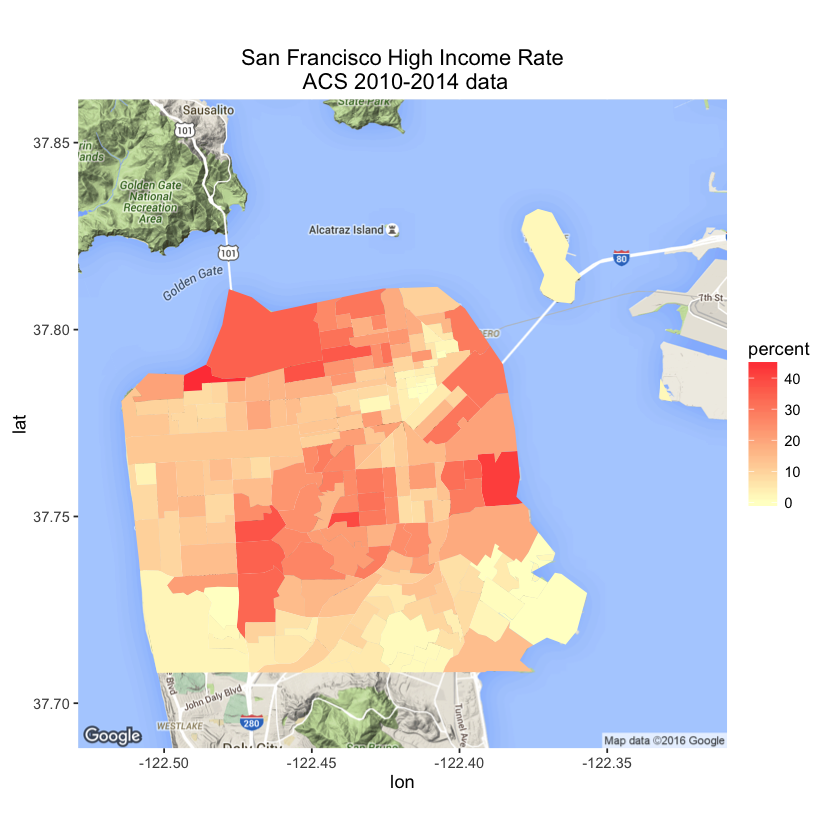

In [13]:
basemap <-get_map('San Francisco', zoom=12) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sf , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Francisco High Income Rate\n ACS 2010-2014 data')

In [14]:
ca_tract_alameda = ca_tract2[grep('Alameda',ca_tract2$GEO.display.label),]
dim(ca_tract_alameda)

[1] 8398   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Hayward&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Hayward&sensor=false


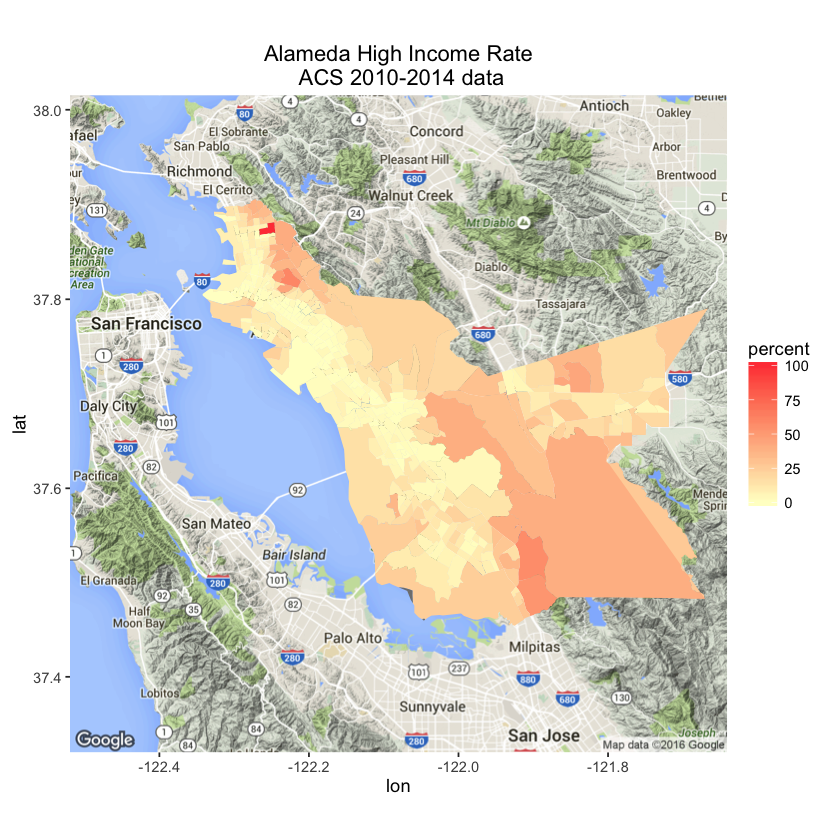

In [15]:
basemap <-get_map('Hayward', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda High Income Rate\n ACS 2010-2014 data')

In [26]:
#remove the tract with 100% high-income to highlight the lower range
ca_data2 = filter(ca_data,percent<100)
dim(ca_data2)

[1] 7982    6

In [27]:
ca_tract3 = left_join(ca_tract,ca_data2, by=c('id'))
dim(ca_tract2)

[1] 330321     12

In [29]:
ca_tract_alameda = ca_tract3[grep('Alameda',ca_tract3$GEO.display.label),]
dim(ca_tract_alameda)

[1] 8361   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Hayward&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Hayward&sensor=false


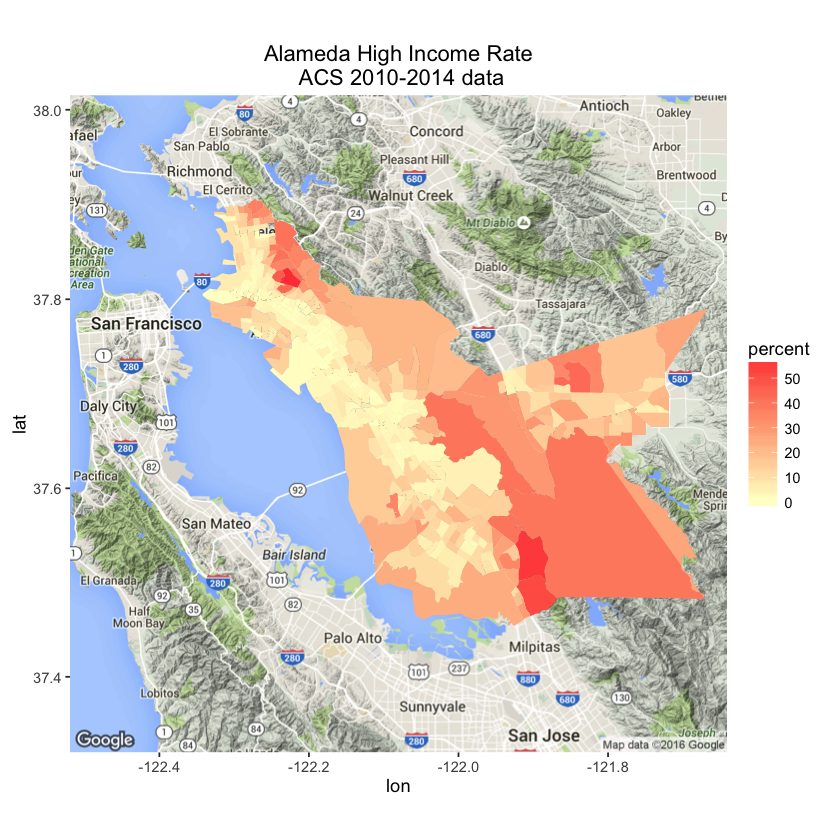

In [30]:
basemap <-get_map('Hayward', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda High Income Rate\n ACS 2010-2014 data')

In [16]:
ca_tract_sanmateo = ca_tract2[grep('San Mateo',ca_tract2$GEO.display.label),]
dim(ca_tract_sanmateo)

[1] 5235   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Mateo&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Mateo&sensor=false


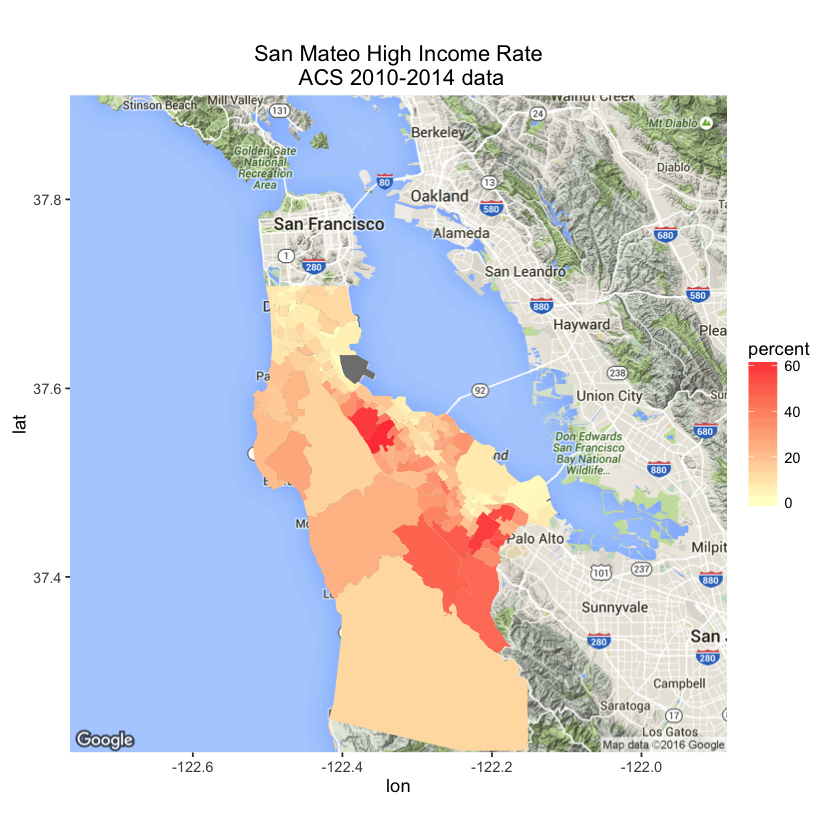

In [17]:
basemap <-get_map('San Mateo', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sanmateo , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Mateo High Income Rate\n ACS 2010-2014 data')

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Leandro&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Leandro&sensor=false


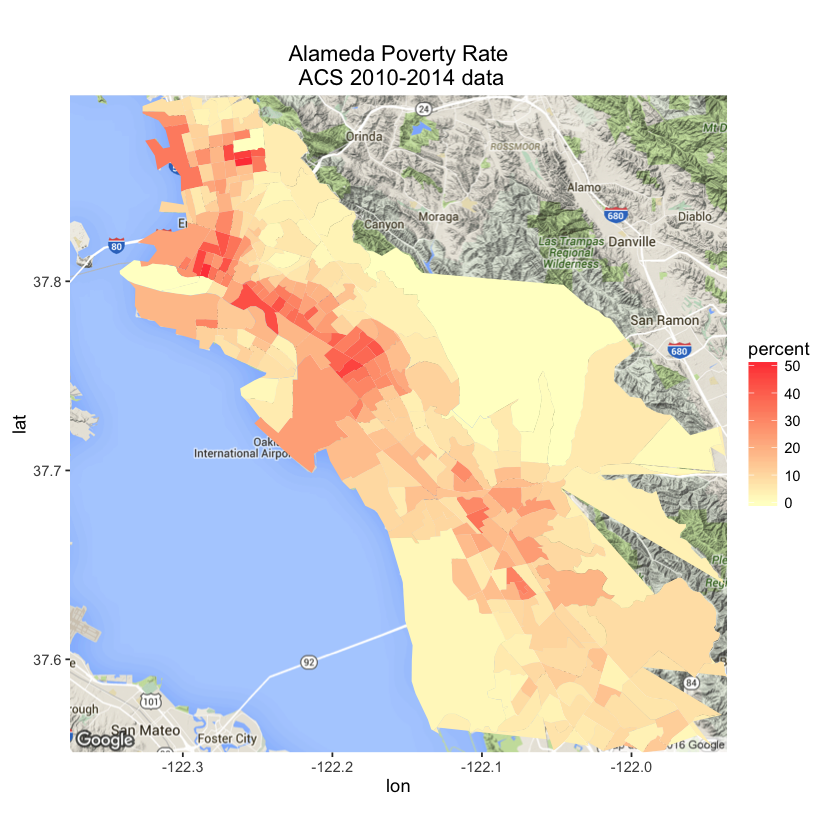

In [19]:
#zoom in on oakland and san leandro
basemap <-get_map('San Leandro', zoom=11) 
ggmap(basemap)+
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda Poverty Rate\n ACS 2010-2014 data')